<a href="https://colab.research.google.com/github/GITaeHUB/PathPlanning/blob/main/Path_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practice Assessment - Path Planning

In this assessment, we will be relying on the [OSMNX library](https://osmnx.readthedocs.io/en/stable/) to generate Python graphs from Open Street Map (OSM) data. These graphs will be represented using the [NetworkX library](https://networkx.github.io/documentation/stable/). Both of these links are to the documentation, which you will find useful in this assessment.

In [21]:
import osmnx as ox
import networkx as nx
import queue
import math
import heapq

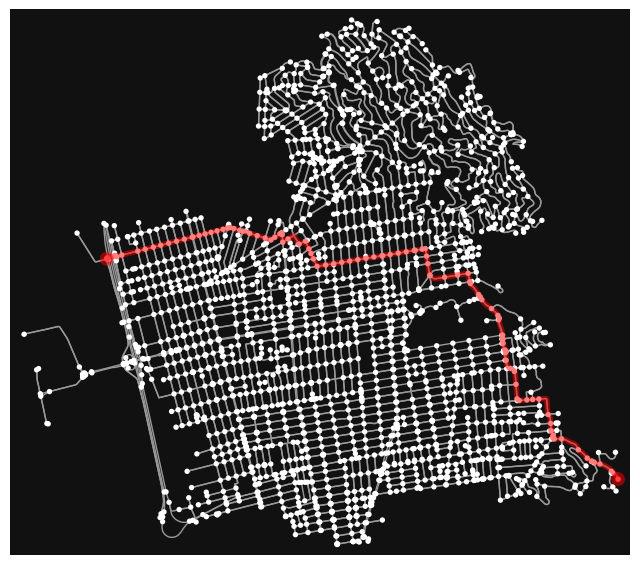

In [41]:
# 지도 그래프 생성
map_graph = ox.graph_from_place('Berkeley, California', network_type='drive')

# 가장 가까운 노드 찾기
origin = ox.distance.nearest_nodes(map_graph, X=-122.226, Y=37.854)
destination = list(map_graph.nodes())[-1]

# 최단 경로 계산
shortest_path = nx.shortest_path(map_graph, origin, destination, weight='length')
fig, ax = ox.plot_graph_route(map_graph, shortest_path)

## Dijkstra's Search
First, let's focus on Dijkstra's algorithm.

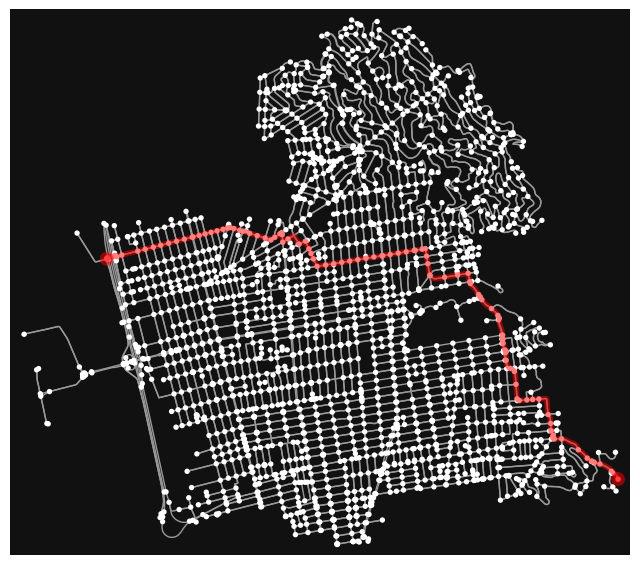

In [42]:
import heapq

# 주어진 그래프, 출발 노드 키, 목표 노드 키를 기반으로 최단 경로를 찾는 다익스트라 알고리즘
def dijkstras_search(origin_key, goal_key, graph):
    # 우선순위 큐(힙)를 초기화
    open_queue = []
    heapq.heappush(open_queue, (0, origin_key))  # (거리, 노드) 형태로 추가

    # 최단 거리와 경로 추적을 위한 딕셔너리 초기화
    distances = {origin_key: 0.0}
    predecessors = {}

    # 목표를 찾기 전까지 큐를 순회
    while open_queue:
        # 우선순위 큐에서 가장 짧은 거리의 노드를 꺼냄
        current_distance, current_node = heapq.heappop(open_queue)

        # 목표 노드에 도달하면 경로 반환
        if current_node == goal_key:
            return get_path(origin_key, goal_key, predecessors)

        # 인접 노드를 탐색하여 최단 거리 갱신
        for neighbor, edge_data in graph[current_node].items():
            edge_length = edge_data[0].get('length', 1)  # 가중치 (기본값 1)
            new_distance = current_distance + edge_length

            # 더 짧은 경로가 발견된 경우 큐와 거리, 선행 노드 정보 업데이트
            if neighbor not in distances or new_distance < distances[neighbor]:
                distances[neighbor] = new_distance
                predecessors[neighbor] = current_node
                heapq.heappush(open_queue, (new_distance, neighbor))

    # 목표 노드를 찾지 못한 경우
    raise ValueError("Goal not found in search.")

# 경로 생성 함수
def get_path(origin_key, goal_key, predecessors):
    path = []
    current = goal_key
    while current != origin_key:
        path.append(current)
        current = predecessors[current]
    path.append(origin_key)
    path.reverse()
    return path

# 예제 사용
map_graph = ox.graph_from_place('Berkeley, California', network_type='drive')
origin = ox.distance.nearest_nodes(map_graph, X=-122.226, Y=37.854)
destination = list(map_graph.nodes())[-1]

# 다익스트라 알고리즘으로 최단 경로 찾기
path = dijkstras_search(origin, destination, map_graph)

# 경로 시각화
fig, ax = ox.plot_graph_route(map_graph, path)

## A* Search
Next, we will use a distance heuristic to implement A* search for our map search problem.

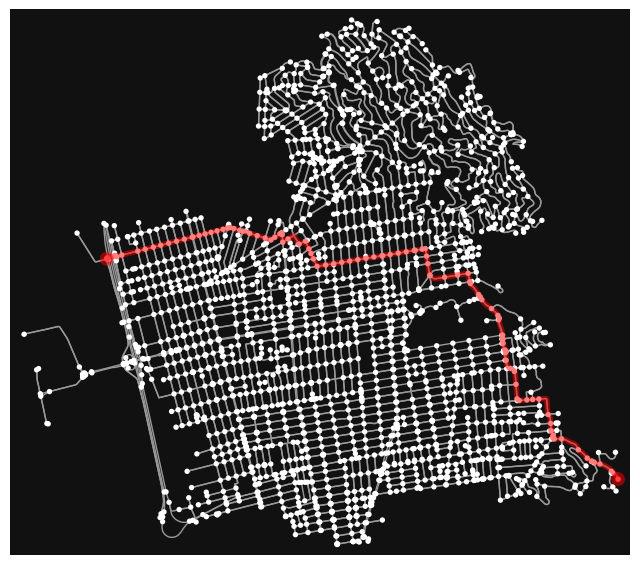

In [43]:
# 두 지점 사이의 유클리드 거리 계산 (구형 지구 모델 사용)
def distance_heuristic(state_key, goal_key, node_data):
    n1 = node_data[state_key]
    n2 = node_data[goal_key]

    # 경도와 위도를 라디안으로 변환
    long1 = n1['x'] * math.pi / 180.0
    lat1 = n1['y'] * math.pi / 180.0
    long2 = n2['x'] * math.pi / 180.0
    lat2 = n2['y'] * math.pi / 180.0

    # 지구 반경 (미터 단위)
    r = 6371000
    x1 = r * math.cos(lat1) * math.cos(long1)
    y1 = r * math.cos(lat1) * math.sin(long1)
    z1 = r * math.sin(lat1)

    x2 = r * math.cos(lat2) * math.cos(long2)
    y2 = r * math.cos(lat2) * math.sin(long2)
    z2 = r * math.sin(lat2)

    d = ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2) ** 0.5
    return d

# A* 알고리즘을 사용하여 최단 경로 찾기
def a_star_search(origin_key, goal_key, graph):
    # 우선순위 큐 초기화
    open_queue = []
    heapq.heappush(open_queue, (0, origin_key))

    # 거리 및 경로 추적을 위한 딕셔너리 초기화
    costs = {origin_key: 0.0}
    predecessors = {}

    # 각 노드의 위치 정보를 저장
    node_data = {node[0]: node[1] for node in graph.nodes(data=True)}

    while open_queue:
        # 큐에서 현재 노드와 현재 비용을 꺼냄
        current_f, current_node = heapq.heappop(open_queue)

        # 목표 노드에 도달하면 경로를 반환
        if current_node == goal_key:
            return get_path(origin_key, goal_key, predecessors)

        # 인접 노드 탐색
        for neighbor, edge_data in graph[current_node].items():
            edge_length = edge_data[0].get('length', 1)  # 간선의 가중치
            new_cost = costs[current_node] + edge_length

            # 더 짧은 경로가 발견된 경우, 비용과 경로 업데이트
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                predecessors[neighbor] = current_node
                f = new_cost + distance_heuristic(neighbor, goal_key, node_data)
                heapq.heappush(open_queue, (f, neighbor))

    # 목표 노드를 찾지 못한 경우
    raise ValueError("Goal not found in search.")

# 경로 생성 함수
def get_path(origin_key, goal_key, predecessors):
    path = []
    current = goal_key
    while current != origin_key:
        path.append(current)
        current = predecessors[current]
    path.append(origin_key)
    path.reverse()
    return path

# 예제 사용
map_graph = ox.graph_from_place('Berkeley, California', network_type='drive')
origin = ox.distance.nearest_nodes(map_graph, X=-122.226, Y=37.854)
destination = list(map_graph.nodes())[-1]

# A* 알고리즘으로 최단 경로 찾기
path = a_star_search(origin, destination, map_graph)

# 경로 시각화
fig, ax = ox.plot_graph_route(map_graph, path)

Congratulations! You've now implemented two important path planning algorithms on real map data.